# Лабораторная работа по EM-алгоритму
В этом задании вам надо дописать код в нескольких ячейках, включая реализацию EM-алгоритма, а также в одной ячейке написать итоговую формулу (она понадобится при реализации алгоритма).

In [1]:
import numpy as np

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

### Задача вероятностного моделирования
Пусть у нас дана выборка объектов $X=\{x_1, ..., x_N\}$, и мы хотим смоделировать распределение над пространством объектов $p(x)$. Это может быть нужно, чтобы научиться создавать такие же объекты искусственно (картинки, тексты и т. д.). Такую задачу решают, например, вариационные автокодировщики и состязающиеся сети (GAN'ы), которые вы изучите на ближайших лекциях. Можно говорить также о моделировании распределения $p(y|x)$ по выборке пар $(x_1, y_1), ..., (x_N, y_N)$, к этой задаче сводятся все задачи обучения с учителем. По своей сути это все задачи вероятностного моделирования какой-то случайной величины, так что мы будем формулировать все конструкции в терминах моделирования $p(x)$, но их точно так же можно записать для разных задач моделирования.

Поиск распределения - задача непростая, и часто ее решают, задавая какое-то параметрическое семейство $p(x|\theta)$ (например, семейство нормальных распределений, параметризуемое средним и дисперсией) и подбирая в нем наиболее подходящие распределения. 

Самый простой способ это делать - метод максимального правдоподобия. В нем мы находим только одну точку $\theta$, при которой распределение хорошо описывает данные, оптимизируя логарифм правдоподобия:
$$\log p(X|\theta) = \sum_{i=1}^N \log p(x_i|\theta) \rightarrow \max_{\theta} $$

_Пример._ Сгенерируем выборку из нормального распределения с загаданными параметрами $\mu=1, \sigma=3$ и попробуем восстановить эти параметры по выборке методом максимального правдоподобия.

Sample: [ 0.1077739  -2.69885537 -1.15017953  2.05647667  3.43316848  0.71576167
  5.11460225  1.09810844 -2.12021153 -3.5551261 ]


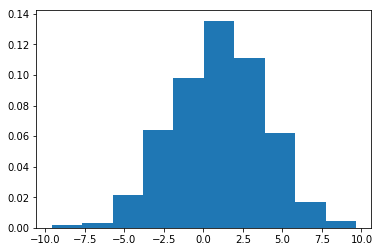

In [3]:
# generate sample
sample = np.random.normal(loc=1, scale=3, size=1000)
print("Sample:", sample[:10])

# plot histogram
_ = plt.hist(sample, normed=True)

Теперь, считая, что, кроме выборки sample у нас ничего нет, моделируем наши данные:

In [4]:
from scipy.stats import norm

Estimated mu and sigma: 0.974464627725 2.96102509804


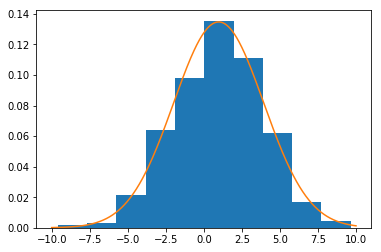

In [5]:
# ML estimate of parameters
mu = sample.mean()
std = sample.std()
print("Estimated mu and sigma:", mu, std)

# plot histogram of data and estimated pdf
_ = plt.hist(sample, normed=True)
ls = np.linspace(-10, 10, 1000) # where to plot pdf
pdf = norm.pdf(ls, loc=mu, scale=std) 
plt.plot(ls, pdf)

### EM-алгоритм

Однако логарифм правдоподобия может оказаться неудобной для оптимизации функцией. Зато если мы введем некоторые скрытые переменные $T$ и запишем правдоподобие $p(X, T|\theta)$ (его еще называют полным правдопдобием), то получим удобную для оптимизации по параметрам $\theta$ функцию. Именно так и делают при применении EM-алгоритма.

Несложно показать, что для любого распределения $q(T)$ выполнено следующее соотношение:

$\log p(X|\theta) = \mathcal{L}(q, \theta) + KL(q(T)||p(T|X, \theta)) = \mathbb{E}_{q(T)} \log \frac {p(X, T|\theta)}{q(T)} + KL(q(T)||p(T|X, \theta))$

Поскольку KL-дивергенция всегда неотрицательна, то $\log p(X|\theta) \leqslant \mathcal{L}(q, \theta)$, и мы можем оптимизировать верхнюю оценку на логарифм правдоподобия, чтобы найти приближенное решение исходной задачи: 
$$\mathcal{L}(q, \theta) \rightarrow \max_{q, \theta} $$

Решать эту задачу мы будем покоординатным спуском, оптимизируя по очереди по скрытым переменным $q$ и по параметрам $\theta$. Обратим внимание, что максимизация $\mathcal{L}(q, \theta)$ по $q$ равносильна минимизации $KL(q(T)||p(T|X, \theta))$ по $q$, а решение этой задачи понятно: $q(T) = p(T|X, \theta)$. В итоге получим следующий алгоритм поиска $q$ и $\theta$, известный под названием EM-алгоритм:

1. Инициализировать $\theta$
2. Повторять до сходимости:
    1. E-шаг: $q(T) = p(T|X, \theta)$
    1. M-шаг: $\theta = argmax_\theta \mathbb{E}_{q(T)} \log p(X, T|\theta)$
    
Часто EM-алгоритм применяют для разделения смесей распределений. Именно это вам и предстоит сделать в задании.

### Модель смеси распределений
Существует много классических семейств вероятностных распределений, про которые мы почти все знаем. Однако зачастую описать какие-то данные в рамках заданного семейства не удается. Один из простых способов задать более сложную модель на основе одного или нескольких классических семейств - это задать вероятностную смесь. 

Пусть у нас есть K распределений $p(x|\theta_k), k=1 ... K$ (будем называть их компонентами смеси), а также вероятности выбора этих компонент $\pi_1, \dots, \pi_K$. Зададим вероятностную модель следующим образом: сначала выбираем компоненту из дискретного распределения $k \sim (\pi_1, \dots, \pi_K)$, а затем генерируем объект из этой компомененты. Плотность вероятности такого распределения будет задаваться следующим образом:
$$p(x|\theta) = \sum_{k=1}^K \pi_k p(x|\theta_k), \quad \theta=\{\theta_q, \dots, \theta_K, \pi_1, \dots, \pi_K\}$$

_Пример._ Рассмотрим смесь двух [распределений Лапласа](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5_%D0%9B%D0%B0%D0%BF%D0%BB%D0%B0%D1%81%D0%B0):
1. Laplace(-1, 0.1) с весом 0.9
1. Laplace(2, 0.5) с весом 0.1

Сгенерируйте выборку размера n из этой смеси (используйте np.random.laplace). Для каждого объекта сохраните, из какой из двух компонент он был сгенерирован!

In [ ]:
n = 1000
### your code here
sample = ...

Посчитайте плотность каждой компоненты в точках ls (запишите в переменные pdf1 и pdf2 соответственно), а также плотность смеси (запишите в переменную pdf):

In [6]:
from scipy.stats import laplace

In [ ]:
### your code here
ls = np.linspace(-3, 7, 1000)
pdf1 = ...
pdf2 = ...
pdf = ...

Нарисуйте гистограму полученной выборки с bins=100, а также все три плотности, подпишите графики на легенде!

In [ ]:
### your code here

### EM-алгоритм для разделения смеси лапласиан

Логарифм правдоподобия смеси лапласиан записывается следующим образом и имеет неудобный вид логарифма суммы:
$$\log p(X|\theta) = \sum_{i=1}^N \log \biggl( \sum_{k=1}^K \pi_k \cdot \frac {1}{2 \lambda_k} \exp \biggl(-\frac{\bigl|x_i-\mu_k\bigr|}{\lambda_k}\biggr) \biggr) , \quad \theta=\{\mu, \lambda, \pi\}$$

Введем скрытые переменные $t_i \in {1, \dots, K}$, показывающие, из какой компоненты пришел $i$-й объект. Тогда получится следующее выражение для логарифма полного правдоподобия (уже без логарифма суммы):
$$\log p(X, T|\theta) = \sum_{i=1}^N \log  \biggl( \pi_{t_i} \cdot \frac {1}{2 \lambda_{t_i}} \exp \biggl(-\frac{\bigl|x_i-\mu_{t_i}\bigr|}{\lambda_{t_i}}\biggr) \biggr)$$
Его также можно переписать в виде с индикатором компоненты, чтобы зависимость от $t$ осталась только в одной части формулы:
$$\log p(X, T|\theta) = \sum_{i=1}^N \sum_{k=1}^K [t_i=k]\log  \biggl( \pi_k \cdot \frac {1}{2 \lambda_k} \exp \biggl(-\frac{\bigl|x_i-\mu_k\bigr|}{\lambda_k}\biggr) \biggr) $$

Чтобы найти параметры $\theta$ нашей модели, воспользуемся EM-алгоритмом.

__E-шаг__: $q(T) = p(T|X, \theta)$. Для поиска апостериорного распределения на скрытые переменные воспользуемся определением условной вероятности:
$$q(T) = p(T|X, \theta) = \frac{p(X, T| \theta)}{\int p(X, \tilde T| \theta) d \tilde T }$$
Поскольку распределение $p(X, T| \theta)$ факторизуется (распадается в произведение по объектам $i$), то же самое произойдет с $q(T)$, и нам достаточно найти отдельные компоненты $q(t_i)$.

Наши скрытые переменные дискретны, поэтому распределение $q(t_i)$ задается $K$ числами $c_{i1}, \dots, c_{iK}$ ($c_{ik}$ - вероятность того, что $t_i=k$), $\sum_{k=1}^K c_{ik} = 1$, $c_{ik} \geqslant 0$. Интеграл в знаменателе превращается в сумму по $k$.

__ЗАДАНИЕ.__ Запишите выражение для $c_{ik}$ так, чтобы в нем участвовали только $x_i$, $\mu_k$, $\lambda_k$ и $\pi_k$.
__\#\#\# Your formula here__

$$ c_{ik} = \frac {}{}$$

__M-шаг:__ $\theta = argmax_\theta \mathbb{E}_{q(T)} \log p(X, T|\theta)$ 

Запишем выражение в правой части:

$$\mathbb{E}_{q(T)} \log p(X, T|\theta) = 
\mathbb{E}_{q(T)} \sum_{i=1}^N \sum_{k=1}^K [t_i=k]\log  \biggl( \pi_k \cdot \frac {1}{2 \lambda_k} \exp \biggl(-\frac{\bigl|x_i-\mu_k\bigr|}{\lambda_k}\biggr) \biggr)= $$

Мат. ожидание и сумма - это линейные операции, их можно менять местами. Поэтому мы проносим мат. ожидание к индикатору:

$$ = 
 \sum_{i=1}^N \sum_{k=1}^K (\mathbb{E}_{q(T)}[t_i=k]) \log  \biggl( \pi_k \cdot \frac {1}{2 \lambda_k} \exp \biggl(-\frac{\bigl|x_i-\mu_k\bigr|}{\lambda_k}\biggr) \biggr) $$
 
Это мат. ожидание зависит только от $q(t_i)$ и равно вероятности события, стоящего под индикатором:
$\mathbb{E}_{q(T)}[t_i=k] = \mathbb{E}_{q(t_i)}[t_i=k] = c_{ik}$.

Получаем следующую оптимизационную задачу M-шага:
$$\sum_{i=1}^N \sum_{k=1}^K c_{ik} \log  \biggl( \pi_k \cdot \frac {1}{2 \lambda_k} \exp \biggl(-\frac{\bigl|x_i-\mu_k\bigr|}{\lambda_k}\biggr) \biggr) \rightarrow \max_{\pi, \mu, \lambda} $$



$$\sum_{i=1}^N \sum_{k=1}^K c_{ik} \biggl(\log \pi_k -log  \lambda_k -\frac{\bigl|x_i-\mu_k\bigr|}{\lambda_k} \biggr) \rightarrow \max_{\pi, \mu, \lambda} $$

_Оптимизация по_ $\pi_k$.

$$\sum_{i=1}^N \sum_{k=1}^K c_{ik} \log \pi_k  \rightarrow \max_{\pi}, \quad \sum_{k=1}^K \pi_k = 1$$

Если выписать лагранжиан для данной задачи и, продифференцировав, приравнять к нулю, получим $\pi_k = \frac {\sum_{i=1}^N c_{ik}}{\sum_{i=1}^N \sum_{k=1}^K c_{ik}} = \frac {\sum_{i=1}^N c_{ik}}{N}$.

_Оптимизация по_ $\mu_k$.
$$ - \sum_{k=1}^K \sum_{i=1}^N  c_{ik} \frac{\bigl|x_i-\mu_k\bigr|}{\lambda_k} \rightarrow \max_{\mu} $$

Эта задача распадается на $K$ независимых задач оптимизации по $\mu_k$:
$$ F(\mu_k) = - \sum_{i=1}^N  \frac{c_{ik}}{\lambda_k} \bigl|x_i-\mu_k\bigr| \rightarrow \max_{\mu_k} $$

Этот функционал минимизирует [взвешенная медиана](https://en.wikipedia.org/wiki/Weighted_median) с весами $\{\frac{c_{ik}}{\lambda_k}\}_{i=1..N}$. Это можно доказать строго, а можно - чуть менее строго через производные:
$$\frac{\partial F}{\partial \mu_k} =  \sum_{i=1}^N  \frac{c_{ik}}{\lambda_k} \begin{cases}1, x_i>\mu_k  \\
-1 , x_i \leqslant \mu_k \end{cases} = 0$$
Отсюда
$$ \sum_{i: x_i>\mu_k}  \frac{c_{ik}}{\lambda_k} = 
 \sum_{i: x_i\leqslant\mu_k}  \frac{c_{ik}}{\lambda_k},$$
 а это и есть определение взвешенной медианы.
 
_Оптимизация по $\lambda.$_ 
$$- \sum_{k=1}^K  \sum_{i=1}^N  c_{ik} \biggl(log  \lambda_k + \frac{\bigl|x_i-\mu_k\bigr|}{\lambda_k} \biggr) \rightarrow \max_{\lambda} $$

Эта задача вновь распадается на $K$ независимых задач оптимизации по $\lambda_k$ и решается дифференцированием с приравниванием к 0: 

$$\lambda_k = \frac {\sum_{i=1}^N c_{ik} \bigl|x_i-\mu_k\bigr|}{\sum_{i=1}^N c_{ik}}.$$

Обратите внимание, что на M-шаге формулы для $\mu_k$ зависят от $\lambda_k$ и для $\lambda_k$ - от $\mu_k$. Эти группы параметров можно обновлять в любом порядке, но если, например, вы сначала обновляете $\mu_k$, а потом $\lambda_k$, то в формулах для $\lambda_k$ нужно использовать уже обновленные на этом шаге $\mu_k$. Параметры $\pi$ стоит обновить самыми первыми, используя $c_{ik}$, посчитанные на E-шаге.

__Многомерный случай.__
Мы рассмотрели EM-алгоритм для разделения смеси одноменых ласпласиан. Если данные многомерные (у объекта несколько признаков), то каждый признак можно моделировать отдельной лапласианой:
$$p(x|\theta) = \sum_{k=1}^K \pi_k \prod_{j=1}^D Laplace(x_j|\mu_{kj}, \lambda_{kj}).$$

Формулы E-шага при этом изменятся с точностью до нового модифицированного вида правдоподобия (то есть почти не изменятся), а формулы M-шага для $\mu_k$ и $\lambda_k$ надо будет использовать отдельно для каждого признака. 

### Реализация EM-алгоритма для разделения смеси лапласиан

Теперь вам нужно реализовать EM-алгоритм для разделения смеси многомерных лапласиан. Инициализируйте параметры и повторяйте E- и M-шаги num_iters раз.

После каждого обновления матрицы переменных ($C$, $\pi$, $\mu$, $\lambda$) вычислите значение $\mathbb{E}_{q(T)} \log p(X, T|\theta)$ (оно должно строго возрастать до сходимости).

Инициализировать параметры $\pi$ можно равномерным дискретным распределением, $\mu$ из $Uniform[-1, 1]$, $\lambda$ - из $Uniform[0, 1]$. 

Для поиска взвешенной медианы используйте модуль [weightedstats](https://pypi.python.org/pypi/weightedstats/0.3).

За реализацию только одномерного случая ($D=1$) штраф -2 балла.

Цикл можно использовать только в EM-алгоритме: цикл по компонентам и по признакам для подсчета взвешенной медианы и, конечно, цикл по итерациям.

In [ ]:
!pip install weightedstats

In [9]:
import weightedstats as ws

In [10]:
num_components = 2 # K 
dim = 1 # D # may be > 1
num_iters = 30

In [17]:
def compute_ELBO(data, C, pi, mu, lamb):
    """
    data: np.ndarray with shape [num_objects, dim]==[N, D]
    C: np.ndarray with shape [num_objects, num_components]
       representing q(T)
    Params of the model (theta):
    pi: np.ndarray with shape [num_components]
    mu: np.ndarray with shape [num_components, dim]
    lamb: np.ndarray with shape [num_components, dim]
    
    returns number: E_q(T) log p(X, T|theta)
    """
    ### your code here
    
    
    
    return elbo

def run_EM(data, num_components, dim, num_iters):
    """
    data: np.ndarray with shape [num_objects, dim]==[N, D]
    
    returns learned q(T) and theta and history of ELBO:
    C: np.ndarray with shape [num_objects, num_components]
       representing q(T)
    Params of the model (theta):
    pi: np.ndarray with shape [num_components]
    mu: np.ndarray with shape [num_components, dim]
    lamb: np.ndarray with shape [num_components, dim]
    elbo: np.ndarray with shape [4*num_iters] 
          representing history of ELBO
    
    """
    ### your code here
    
    return C, mu, pi, lamb, elbo
    

Протестируйте реализованный алгоритм на искусственно сгенерированных данных. Получилось ли у алгоритма восстановить настоящие компоненты, из которых мы генерировали данные? А их соотношение?

In [ ]:
### your code here

Изобразите график обновлений ELBO и график разностей соседних значений ELBO (чтобы убедиться, что до сходимости ELBO все время возрастает):

In [ ]:
### your code here

Изобразите scatter-plot, по одной оси которого - номер компоненты, из которой был сгенерирован объект (для этого его нужно было сохранять при генерации данных), по другой оси - восстановленная вероятность нулевой компоненты для этого объекта. Получилось ли у алгоритма восстановить принадлежность объектов к компонентам?

In [ ]:
### your code here